Copyright (c) Microsoft Corporation. All rights reserved.

# Predict NYC taxi fares by GBDT

In [138]:
from pathlib import Path
import os
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [139]:
# Read raw data from csv to dataframe
raw_data = '../data/sample_data/'
print("raw data files: ")
arr = os.listdir(raw_data)
print(arr)

green_data = pd.read_csv((Path(raw_data) / 'greenTaxiData.csv'))
yellow_data = pd.read_csv((Path(raw_data) / 'yellowTaxiData.csv'))

raw data files: 
['greenTaxiData.csv', 'yellowTaxiData.csv']


In [140]:
print(green_data.shape)
print(yellow_data.shape)

(5000, 21)
(5000, 19)


In [141]:
green_data.head(5)

,vendorID,lpepPickupDatetime,lpepDropoffDatetime,passengerCount,tripDistance,pickupLongitude,pickupLatitude,dropoffLongitude,dropoffLatitude,rateCodeID,...,paymentType,fareAmount,extra,mtaTax,improvementSurcharge,tipAmount,tollsAmount,ehailFee,totalAmount,tripType
0,2,2016-02-04 21:44:19,2016-02-04 21:48:07,1,0.69,-73.912086,40.861900,-73.903397,40.861099,1,...,2,5.0,0.5,0.5,0.3,0.0,0.0,NaN,6.3,1.0
1,2,2016-02-05 08:04:41,2016-02-05 08:12:23,1,1.59,-73.940269,40.825184,-73.951118,40.806831,1,...,2,7.5,0.0,0.5,0.3,0.0,0.0,NaN,8.3,1.0
2,1,2016-04-19 04:52:06,2016-04-19 05:02:45,1,3.20,-73.968697,40.689514,-73.998581,40.713619,1,...,3,12.0,0.5,0.5,0.3,0.0,0.0,NaN,13.3,1.0
3,2,2016-06-10 21:36:17,2016-06-10 21:45:14,1,1.47,-73.943924,40.795544,-73.951500,40.809547,1,...,2,8.0,0.5,0.5,0.3,0.0,0.0,NaN,9.3,1.0
4,1,2016-02-27 15:21:30,2016-02-27 15:35:12,1,1.70,-73.937439,40.801342,-73.959412,40.815529,1,...,2,10.0,0.0,0.5,0.3,0.0,0.0,NaN,10.8,1.0


In [142]:
yellow_data.head(5)

,vendorID,tpepPickupDateTime,tpepDropoffDateTime,passengerCount,tripDistance,startLon,startLat,endLon,endLat,rateCodeId,storeAndFwdFlag,paymentType,fareAmount,extra,mtaTax,improvementSurcharge,tipAmount,tollsAmount,totalAmount
0,1,2016-02-04 23:24:28,2016-02-04 23:50:01,1,6.00,-73.981979,40.778084,-73.940598,40.725220,1,N,1,22.0,0.5,0.5,0.3,4.65,0.0,27.95
1,2,2016-04-02 18:47:11,2016-04-02 18:57:20,3,1.85,-73.960480,40.761753,-73.982964,40.775757,1,N,1,9.0,0.0,0.5,0.3,1.96,0.0,11.76
2,1,2016-03-23 21:36:20,2016-03-23 21:46:08,1,1.40,-73.992905,40.734283,-74.005455,40.725613,1,N,2,8.0,0.5,0.5,0.3,0.00,0.0,9.30
3,1,2016-05-11 19:53:07,2016-05-11 20:03:43,1,1.30,-73.982147,40.740177,-73.986465,40.726547,1,N,2,8.0,0.5,0.5,0.3,0.00,0.0,9.30
4,2,2016-03-14 22:59:53,2016-03-14 23:33:26,1,8.42,-73.985413,40.743042,-73.944862,40.829067,1,N,2,28.5,0.5,0.5,0.3,0.00,0.0,29.80


In [143]:
yellow_data.describe()

,vendorID,passengerCount,tripDistance,startLon,startLat,endLon,endLat,rateCodeId,paymentType,fareAmount,extra,mtaTax,improvementSurcharge,tipAmount,tollsAmount,totalAmount
count,5000.0000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.5418,1.671800,2.989760,-72.938002,40.180239,-72.967084,40.197368,1.081400,1.355800,12.976010,0.342800,0.496600,0.299280,1.810876,0.326208,16.252554
std,0.4983,1.336279,3.668994,8.692146,4.788384,8.568746,4.720564,1.979484,0.491177,10.750153,0.488094,0.045704,0.018962,2.446819,1.430909,13.485274
min,1.0000,0.000000,0.000000,-74.102463,0.000000,-74.236092,0.000000,1.000000,1.000000,-5.500000,-0.500000,-0.500000,-0.300000,0.000000,0.000000,-6.800000
25%,1.0000,1.000000,1.007500,-73.991638,40.736280,-73.990831,40.734507,1.000000,1.000000,6.500000,0.000000,0.500000,0.300000,0.000000,0.000000,8.750000
50%,2.0000,1.000000,1.730000,-73.981731,40.753662,-73.979263,40.753586,1.000000,1.000000,9.500000,0.000000,0.500000,0.300000,1.260000,0.000000,11.800000
75%,2.0000,2.000000,3.180000,-73.966694,40.767531,-73.961468,40.769391,1.000000,2.000000,14.500000,0.500000,0.500000,0.300000,2.450000,0.000000,17.800000
max,2.0000,6.000000,37.500000,0.000000,40.893429,0.000000,40.955765,99.000000,4.000000,115.000000,4.500000,0.500000,0.300000,21.050000,19.700000,115.300000


In [144]:
# Define useful columns 
useful_columns = [
        "cost",
        "distance",
        "dropoff_datetime",
        "dropoff_latitude",
        "dropoff_longitude",
        "passengers",
        "pickup_datetime",
        "pickup_latitude",
        "pickup_longitude",
        "store_forward",
        "vendor",
    ]

print(useful_columns)


green_columns = {
        "vendorID": "vendor",
        "lpepPickupDatetime": "pickup_datetime",
        "lpepDropoffDatetime": "dropoff_datetime",
        "storeAndFwdFlag": "store_forward",
        "pickupLongitude": "pickup_longitude",
        "pickupLatitude": "pickup_latitude",
        "dropoffLongitude": "dropoff_longitude",
        "dropoffLatitude": "dropoff_latitude",
        "passengerCount": "passengers",
        "fareAmount": "cost",
        "tripDistance": "distance",
    }


yellow_columns = {
        "vendorID": "vendor",
        "tpepPickupDateTime": "pickup_datetime",
        "tpepDropoffDateTime": "dropoff_datetime",
        "storeAndFwdFlag": "store_forward",
        "startLon": "pickup_longitude",
        "startLat": "pickup_latitude",
        "endLon": "dropoff_longitude",
        "endLat": "dropoff_latitude",
        "passengerCount": "passengers",
        "fareAmount": "cost",
        "tripDistance": "distance",
    }


print("green_columns: ", green_columns)
print("yellow_columns: ", yellow_columns)

['cost', 'distance', 'dropoff_datetime', 'dropoff_latitude', 'dropoff_longitude', 'passengers', 'pickup_datetime', 'pickup_latitude', 'pickup_longitude', 'store_forward', 'vendor']
green_columns:  {'vendorID': 'vendor', 'lpepPickupDatetime': 'pickup_datetime', 'lpepDropoffDatetime': 'dropoff_datetime', 'storeAndFwdFlag': 'store_forward', 'pickupLongitude': 'pickup_longitude', 'pickupLatitude': 'pickup_latitude', 'dropoffLongitude': 'dropoff_longitude', 'dropoffLatitude': 'dropoff_latitude', 'passengerCount': 'passengers', 'fareAmount': 'cost', 'tripDistance': 'distance'}
yellow_columns:  {'vendorID': 'vendor', 'tpepPickupDateTime': 'pickup_datetime', 'tpepDropoffDateTime': 'dropoff_datetime', 'storeAndFwdFlag': 'store_forward', 'startLon': 'pickup_longitude', 'startLat': 'pickup_latitude', 'endLon': 'dropoff_longitude', 'endLat': 'dropoff_latitude', 'passengerCount': 'passengers', 'fareAmount': 'cost', 'tripDistance': 'distance'}


In [145]:
# Rename and remove columns
green_data.rename(columns=green_columns, inplace=True)
green_data_clean = green_data[useful_columns]
print('data size before removing columns: ', green_data.shape)
print('data size after removing columns: ', green_data_clean.shape)

yellow_data.rename(columns=yellow_columns, inplace=True)
yellow_data_clean = (yellow_data)[useful_columns]
print('data size before removing columns: ', yellow_data.shape)
print('data size after removing columns: ', yellow_data_clean.shape)

data size before removing columns:  (5000, 21)
data size after removing columns:  (5000, 11)
data size before removing columns:  (5000, 19)
data size after removing columns:  (5000, 11)


In [146]:
# Drop NaN
green_data_clean = green_data_clean.dropna(axis=0, how='any')
yellow_data_clea = yellow_data_clean.dropna(axis=0, how='any')

In [147]:
# Count total NaN at each column 
print(green_data_clean.isnull().sum())
print(yellow_data_clean.isnull().sum())

cost                 0
distance             0
dropoff_datetime     0
dropoff_latitude     0
dropoff_longitude    0
passengers           0
pickup_datetime      0
pickup_latitude      0
pickup_longitude     0
store_forward        0
vendor               0
dtype: int64
cost                 0
distance             0
dropoff_datetime     0
dropoff_latitude     0
dropoff_longitude    0
passengers           0
pickup_datetime      0
pickup_latitude      0
pickup_longitude     0
store_forward        0
vendor               0
dtype: int64


In [148]:
# Check statistics of the features
green_data_clean.describe()

,cost,distance,dropoff_latitude,dropoff_longitude,passengers,pickup_latitude,pickup_longitude,vendor
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,12.213648,2.820044,40.679949,-73.825285,1.326400,40.682344,-73.826663,1.783600
std,10.109738,3.008411,1.630993,3.013091,0.970799,1.631071,3.013020,0.411831
min,-5.000000,0.000000,0.000000,-115.166878,1.000000,0.000000,-115.171654,1.000000
25%,6.500000,1.050000,40.697060,-73.968437,1.000000,40.695974,-73.960526,2.000000
50%,9.000000,1.820000,40.747013,-73.945087,1.000000,40.746658,-73.947033,2.000000
75%,15.000000,3.550000,40.790910,-73.911930,1.000000,40.802317,-73.918905,2.000000
max,250.000000,58.600000,40.909142,0.000000,7.000000,40.886688,0.000000,2.000000


In [149]:
yellow_data_clean.describe()

,cost,distance,dropoff_latitude,dropoff_longitude,passengers,pickup_latitude,pickup_longitude,vendor
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.0000
mean,12.976010,2.989760,40.197368,-72.967084,1.671800,40.180239,-72.938002,1.5418
std,10.750153,3.668994,4.720564,8.568746,1.336279,4.788384,8.692146,0.4983
min,-5.500000,0.000000,0.000000,-74.236092,0.000000,0.000000,-74.102463,1.0000
25%,6.500000,1.007500,40.734507,-73.990831,1.000000,40.736280,-73.991638,1.0000
50%,9.500000,1.730000,40.753586,-73.979263,1.000000,40.753662,-73.981731,2.0000
75%,14.500000,3.180000,40.769391,-73.961468,2.000000,40.767531,-73.966694,2.0000
max,115.000000,37.500000,40.955765,0.000000,6.000000,40.893429,0.000000,2.0000


In [150]:
# Append yellow data to green data
combined_df = green_data_clean.append(yellow_data_clean, ignore_index=True)
combined_df.reset_index(inplace=True, drop=True)
print("combined data size:", combined_df.shape)


combined data size: (10000, 11)


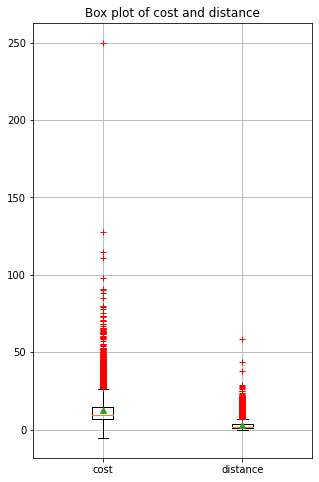

In [151]:
# Plot box and histogram to check data distribution
fig, axes = plt.subplots(figsize=(5, 8))
plt.title('Box plot of cost and distance')
plt.grid(True)  
plt.boxplot([combined_df.cost, combined_df.distance], labels=['cost', 'distance'], sym="r+", showmeans=True) 
plt.show()  

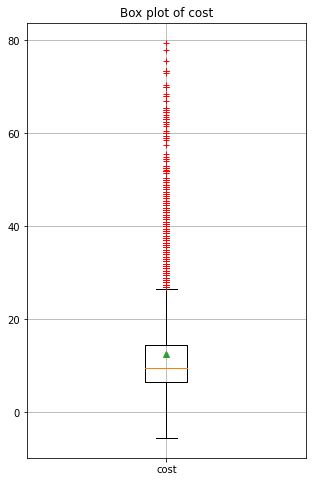

In [152]:
# Plot box and histogram to check data distribution
fig, axes = plt.subplots(figsize=(5, 8))
plt.title('Box plot of cost')
plt.grid(True)  
plt.boxplot(combined_df[combined_df.cost<80].cost, labels=['cost'], sym="r+", showmeans=True) 
plt.show()  

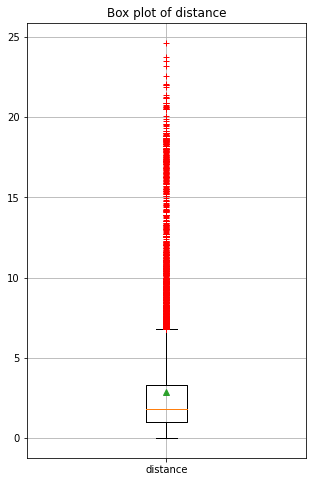

In [153]:
# Plot box and histogram to check data distribution
fig, axes = plt.subplots(figsize=(5, 8))
plt.title('Box plot of distance')
plt.grid(True)  
plt.boxplot(combined_df[combined_df.distance<25].distance, labels=['distance'], sym="r+", showmeans=True) 
plt.show()  

Text(0.5, 1.0, 'Histogram of cost')

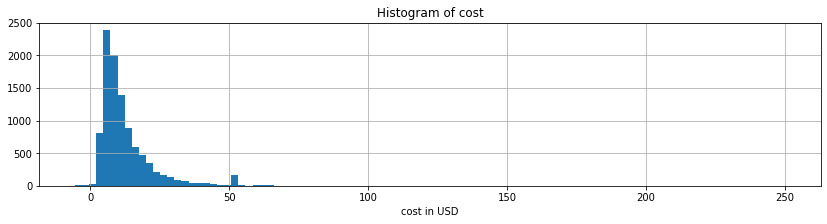

In [154]:
# Plot histogram of cost
combined_df.cost.hist(bins=100, figsize=(14, 3))
plt.xlabel('cost in USD')
plt.title('Histogram of cost')

Text(0.5, 1.0, 'Histogram of cost')

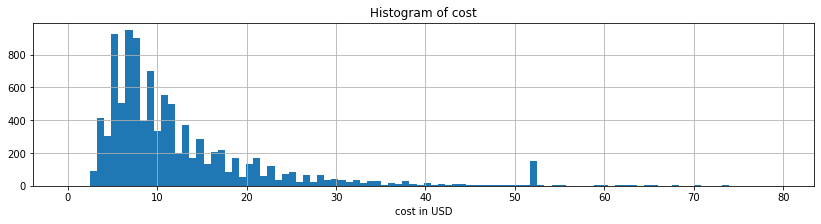

In [155]:
# Plot histogram of cost
combined_df[(combined_df.cost>0) & (combined_df.cost<80)].cost.hist(bins=100, figsize=(14, 3))
plt.xlabel('cost in USD')
plt.title('Histogram of cost')

Text(0.5, 1.0, 'Histogram of distance')

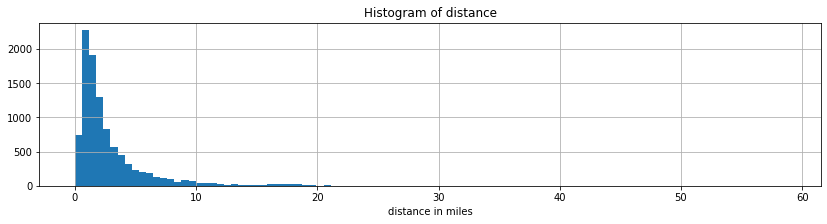

In [156]:
# Plot histogram of distance
combined_df.distance.hist(bins=100, figsize=(14, 3))
plt.xlabel('distance in miles')
plt.title('Histogram of distance')

Text(0.5, 1.0, 'Histogram of distance')

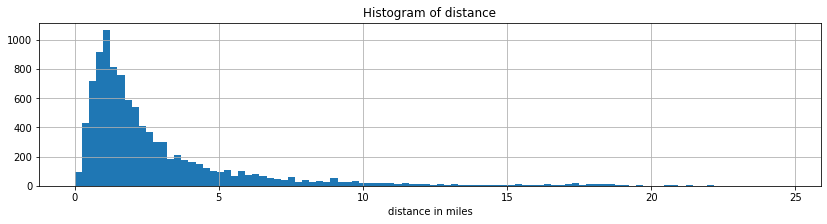

In [157]:
# Plot histogram of cost
combined_df[(combined_df.distance>0) & (combined_df.distance<25)].distance.hist(bins=100, figsize=(14, 3))
plt.xlabel('distance in miles')
plt.title('Histogram of distance')

In [158]:
# Filter outliers by cost and disatnce.

combined_df_cost = combined_df[(combined_df.cost > 0) & (combined_df.cost  < 80)]
print('data size after removing cost outliers: %d' % len(combined_df_cost))

combined_df_cost_distance = combined_df_cost[(combined_df_cost.distance > 0) & (combined_df_cost.distance  < 25)]
print('data size after removing distance outliers: %d' % len(combined_df_cost_distance))

combined_df_cost_distance.reset_index(inplace=True, drop=True)

data size after removing cost filers: 9948
data size after removing distance filers: 9858


In [159]:
# Filter out coordinates for locations that are outside the city border.

combined_df_cost_distance = combined_df_cost_distance.astype(
    {
        "pickup_longitude": "float64",
        "pickup_latitude": "float64",
        "dropoff_longitude": "float64",
        "dropoff_latitude": "float64",
    }
)

latlong_filtered_df = combined_df_cost_distance[
    (combined_df_cost_distance.pickup_longitude <= -73.72)
    & (combined_df_cost_distance.pickup_longitude >= -74.09)
    & (combined_df_cost_distance.pickup_latitude <= 40.88)
    & (combined_df_cost_distance.pickup_latitude >= 40.53)
    & (combined_df_cost_distance.dropoff_longitude <= -73.72)
    & (combined_df_cost_distance.dropoff_longitude >= -74.72)
    & (combined_df_cost_distance.dropoff_latitude <= 40.88)
    & (combined_df_cost_distance.dropoff_latitude >= 40.53)
]

latlong_filtered_df.reset_index(inplace=True, drop=True)
print('data size after filtering locations:', latlong_filtered_df.shape)


data size after filtering locations: (9743, 11)


In [160]:
# Split the pickup and dropoff date further into the day of the week, day of the month, and month values.

datetime_splited_df = pd.DataFrame(latlong_filtered_df)

temp = pd.DatetimeIndex(latlong_filtered_df["pickup_datetime"], dtype="datetime64[ns]")
datetime_splited_df["pickup_date"] = temp.date
datetime_splited_df["pickup_weekday"] = temp.dayofweek
datetime_splited_df["pickup_month"] = temp.month
datetime_splited_df["pickup_monthday"] = temp.day
datetime_splited_df["pickup_time"] = temp.time
datetime_splited_df["pickup_hour"] = temp.hour
datetime_splited_df["pickup_minute"] = temp.minute
datetime_splited_df["pickup_second"] = temp.second

temp = pd.DatetimeIndex(latlong_filtered_df["dropoff_datetime"], dtype="datetime64[ns]")
datetime_splited_df["dropoff_date"] = temp.date
datetime_splited_df["dropoff_weekday"] = temp.dayofweek
datetime_splited_df["dropoff_month"] = temp.month
datetime_splited_df["dropoff_monthday"] = temp.day
datetime_splited_df["dropoff_time"] = temp.time
datetime_splited_df["dropoff_hour"] = temp.hour
datetime_splited_df["dropoff_minute"] = temp.minute
datetime_splited_df["dropoff_second"] = temp.second

del datetime_splited_df["pickup_datetime"]
del datetime_splited_df["dropoff_datetime"]

datetime_splited_df.reset_index(inplace=True, drop=True)


print(datetime_splited_df.dtypes)

cost                 float64
distance             float64
dropoff_latitude     float64
dropoff_longitude    float64
passengers             int64
pickup_latitude      float64
pickup_longitude     float64
store_forward         object
vendor                 int64
pickup_date           object
pickup_weekday         int64
pickup_month           int64
pickup_monthday        int64
pickup_time           object
pickup_hour            int64
pickup_minute          int64
pickup_second          int64
dropoff_date          object
dropoff_weekday        int64
dropoff_month          int64
dropoff_monthday       int64
dropoff_time          object
dropoff_hour           int64
dropoff_minute         int64
dropoff_second         int64
dtype: object


In [161]:
datetime_splited_df.head(5)

,cost,distance,dropoff_latitude,dropoff_longitude,passengers,pickup_latitude,pickup_longitude,store_forward,vendor,pickup_date,...,pickup_minute,pickup_second,dropoff_date,dropoff_weekday,dropoff_month,dropoff_monthday,dropoff_time,dropoff_hour,dropoff_minute,dropoff_second
0,5.0,0.69,40.861099,-73.903397,1,40.861900,-73.912086,N,2,2016-02-04,...,44,19,2016-02-04,3,2,4,21:48:07,21,48,7
1,7.5,1.59,40.806831,-73.951118,1,40.825184,-73.940269,N,2,2016-02-05,...,4,41,2016-02-05,4,2,5,08:12:23,8,12,23
2,12.0,3.20,40.713619,-73.998581,1,40.689514,-73.968697,N,1,2016-04-19,...,52,6,2016-04-19,1,4,19,05:02:45,5,2,45
3,8.0,1.47,40.809547,-73.951500,1,40.795544,-73.943924,N,2,2016-06-10,...,36,17,2016-06-10,4,6,10,21:45:14,21,45,14
4,10.0,1.70,40.815529,-73.959412,1,40.801342,-73.937439,N,1,2016-02-27,...,21,30,2016-02-27,5,2,27,15:35:12,15,35,12


In [162]:
# Drop the pickup_date, dropoff_date, pickup_time, dropoff_time columns because they're
# no longer needed (granular time features like hour,
# minute and second are more useful for model training).
del datetime_splited_df["pickup_date"]
del datetime_splited_df["dropoff_date"]
del datetime_splited_df["pickup_time"]
del datetime_splited_df["dropoff_time"]

print('data size after splitting datetime:',  datetime_splited_df.shape)

data size after splitting datetime: (9743, 21)


In [163]:
# Change the store_forward column to binary values
train_data = datetime_splited_df
train_data["store_forward"] = np.where((datetime_splited_df.store_forward == "N"), 0, 1)

In [164]:
train_data.head(5)

,cost,distance,dropoff_latitude,dropoff_longitude,passengers,pickup_latitude,pickup_longitude,store_forward,vendor,pickup_weekday,...,pickup_monthday,pickup_hour,pickup_minute,pickup_second,dropoff_weekday,dropoff_month,dropoff_monthday,dropoff_hour,dropoff_minute,dropoff_second
0,5.0,0.69,40.861099,-73.903397,1,40.861900,-73.912086,0,2,3,...,4,21,44,19,3,2,4,21,48,7
1,7.5,1.59,40.806831,-73.951118,1,40.825184,-73.940269,0,2,4,...,5,8,4,41,4,2,5,8,12,23
2,12.0,3.20,40.713619,-73.998581,1,40.689514,-73.968697,0,1,1,...,19,4,52,6,1,4,19,5,2,45
3,8.0,1.47,40.809547,-73.951500,1,40.795544,-73.943924,0,2,4,...,10,21,36,17,4,6,10,21,45,14
4,10.0,1.70,40.815529,-73.959412,1,40.801342,-73.937439,0,1,5,...,27,15,21,30,5,2,27,15,35,12


In [165]:
# Split the data into input(X) and output(y)
y = train_data["cost"]
# X = train_data.drop(['cost'], axis=1)
X = train_data[
    [
        "distance",
        "dropoff_latitude",
        "dropoff_longitude",
        "passengers",
        "pickup_latitude",
        "pickup_longitude",
        "store_forward",
        "vendor",
        "pickup_weekday",
        "pickup_month",
        "pickup_monthday",
        "pickup_hour",
        "pickup_minute",
        "pickup_second",
        "dropoff_weekday",
        "dropoff_month",
        "dropoff_monthday",
        "dropoff_hour",
        "dropoff_minute",
        "dropoff_second",
    ]
]


In [166]:
# Split the data into train and test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.3, random_state=42)
print(trainX.shape)
print(trainX.columns)


(6820, 20)
Index(['distance', 'dropoff_latitude', 'dropoff_longitude', 'passengers',
       'pickup_latitude', 'pickup_longitude', 'store_forward', 'vendor',
       'pickup_weekday', 'pickup_month', 'pickup_monthday', 'pickup_hour',
       'pickup_minute', 'pickup_second', 'dropoff_weekday', 'dropoff_month',
       'dropoff_monthday', 'dropoff_hour', 'dropoff_minute', 'dropoff_second'],
      dtype='object')


In [167]:
# Train a GBDT Regressor Model with the train set
learning_rate = 0.1
n_estimators = 100
model = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators = n_estimators).fit(trainX, trainy)
print("training set score:", model.score(trainX, trainy))

training set score: 0.9402301722232184


In [168]:
# Output the model 
model_output = './model/'
if not os.path.exists(model_output):
    os.mkdir(model_output)
pickle.dump(model, open((Path(model_output) / "model.sav"), "wb"))

In [169]:
# Make predictions on testX data and record them in a column named predicted_cost
predictions = model.predict(testX)

In [170]:
# Compare predictions to actuals (testy)
# The mean squared error
print("Scored with the following model:\n{}".format(model))
print("Mean squared error: %.2f" % mean_squared_error(testy, predictions))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(testy, predictions))

Scored with the following model:
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
Mean squared error: 6.05
Coefficient of determination: 0.93
